<a href="https://colab.research.google.com/github/NaHyeonMaeng/CODE_Practice/blob/main/%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%ED%95%A0(segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필수 라이브러리 불러오기
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
#주요 파라미터 설정

# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w,img_h,img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [3]:
# 텐서플로 데이터셋(옥스포드 반려동물 데이터셋) 로드
ds_str='oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteON9Z67/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteON9Z67/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
# 이미지 전처리 함수 정의
def preprocess_image(ds):
    # 원본 이미지
    img = tf.image.resize(ds['image'], (img_w, img_h))
    img = tf.cast(img, tf.float32) / 255.0
    # 분할 마스크
    mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
    mask = tf.cast(mask, tf.int32)
    mask = mask - 1    #마스크는 0, 1, 2의 정수형 값을 갖도록 1을 차감함 (각 픽셀에 대한 범주 레이블 개수에 맞도록)
    return img, mask

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

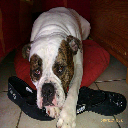

In [7]:
# 샘플 이미지 출력
img = np.array(img[0])*255.0   #255를 곱해서 정규화 이전의 원래 값으로 복원
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

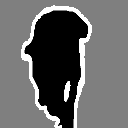

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0  #마스크 범위는 0~2이므로 2로 나눈 다음에 255를 곱함
cv2_imshow(mask)

전이학습

In [9]:
# VGG16 모델을 인코더로 활용하는 U-Net 모델 만들기
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)  #최종 레이어 제외

58889256/58889256 [==============================] - 4s 0us/step


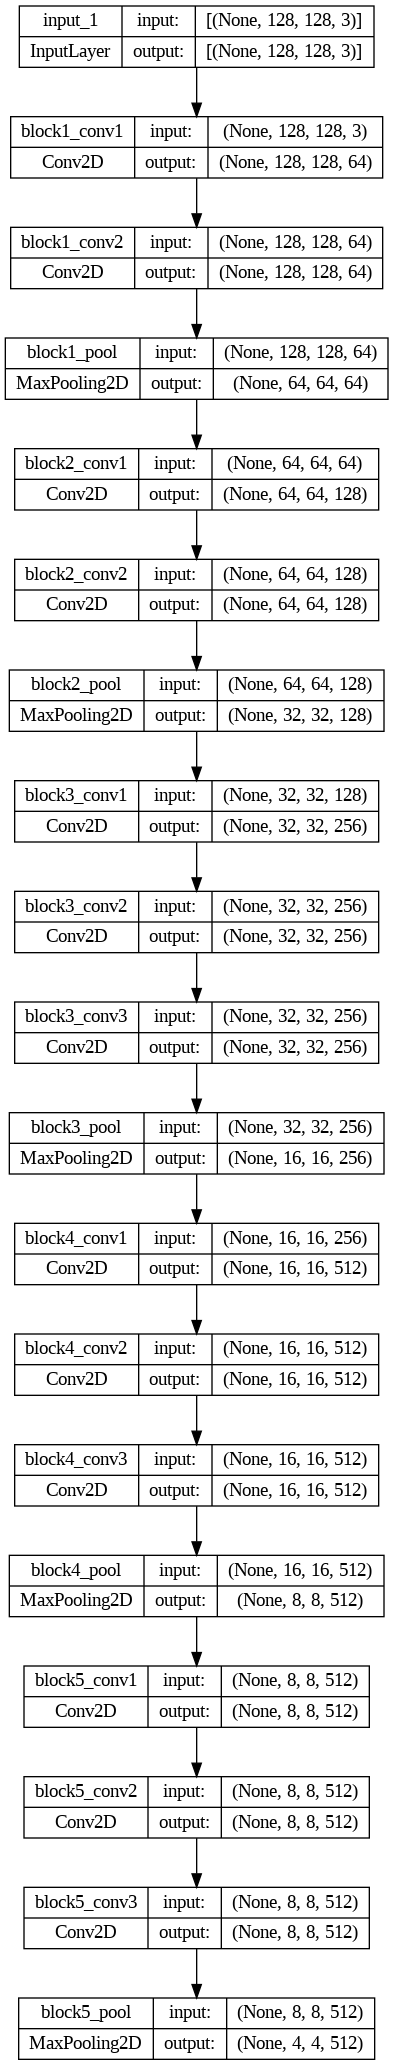

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model,show_shapes=True)

U-Net 모델 정의

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정 (VGG16 모델에서 1개의 입력과 5개의 출력을 가져옴)
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[
                                base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output
])

In [12]:
# 파라미터 고정 (학습된 파라미터를 인코더에 그대로 사용하기 위함)
f_model.trainable = False

In [13]:
# U-Net 구조로 모델 정의 (인코더 부분에서 5개의 추력을 가져와서 디코더의 입력으로 전달하며 '업샘플링'함)

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out,out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out = tf.keras.layers.Add()([out,out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same') (out)
out = tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

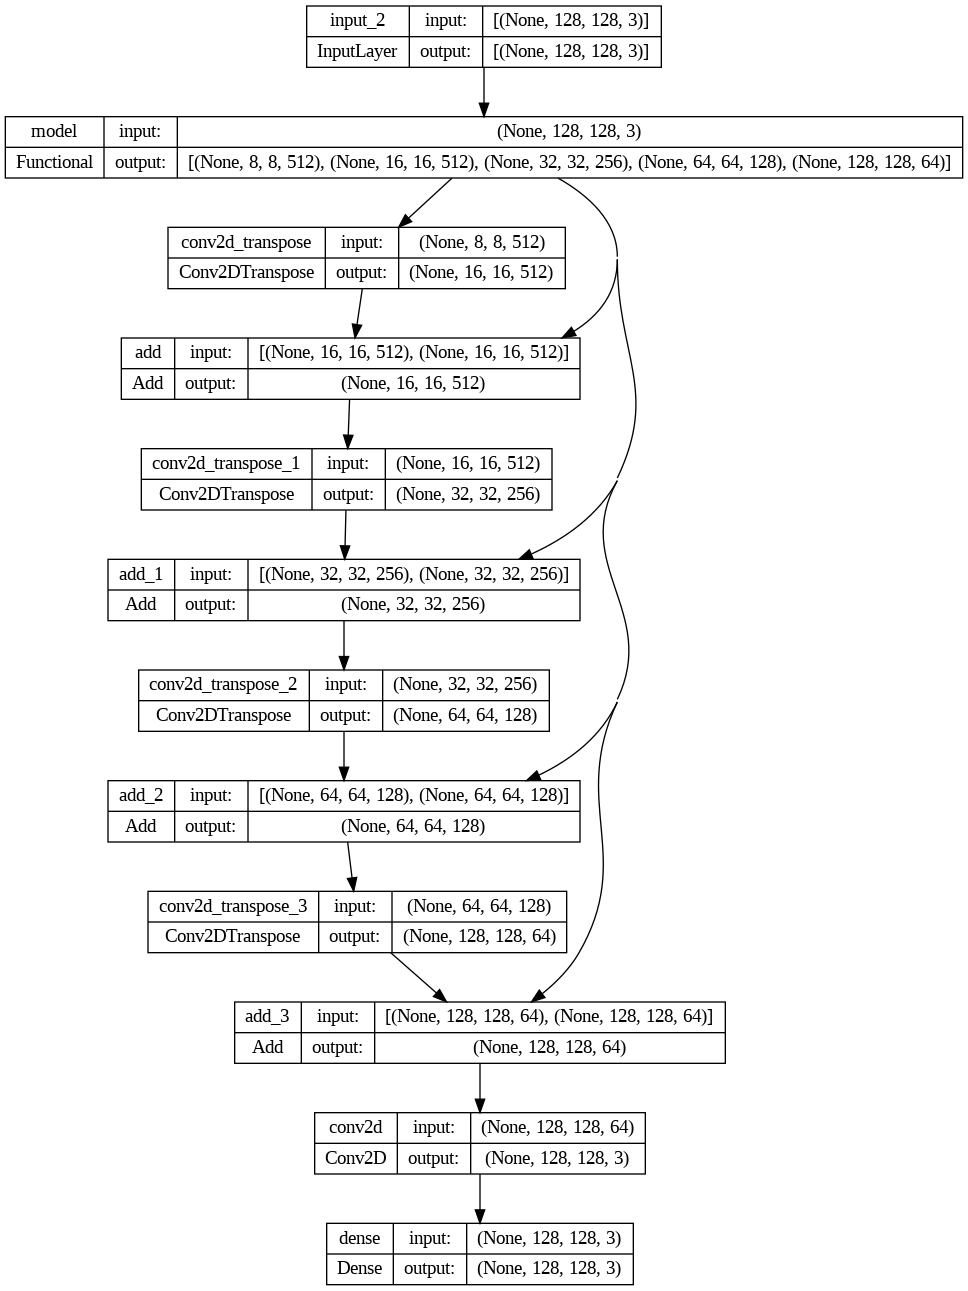

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()   #다중 분류 문제에 맞는 손실함수 설정
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 39s 77ms/step - loss: 0.8961 - accuracy: 0.6052
Epoch 2/5
230/230 [==============================] - 19s 72ms/step - loss: 0.5641 - accuracy: 0.7900
Epoch 3/5
230/230 [==============================] - 19s 73ms/step - loss: 0.4899 - accuracy: 0.8176
Epoch 4/5
230/230 [==============================] - 21s 74ms/step - loss: 0.4573 - accuracy: 0.8285
Epoch 5/5
230/230 [==============================] - 20s 74ms/step - loss: 0.4363 - accuracy: 0.8366


추론: test 데이터셋을 모델에 입력하여 이미지 분할 예측

1/1 [==============================] - 0s 307ms/step


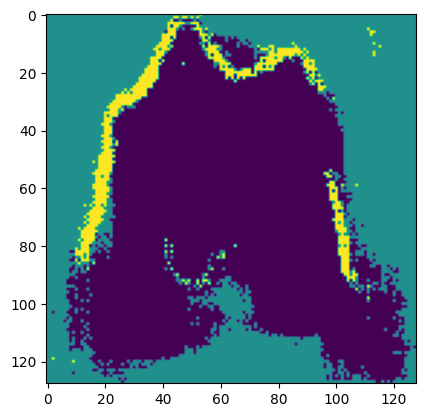

In [17]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0], -1)
plt.imshow(pred_img)

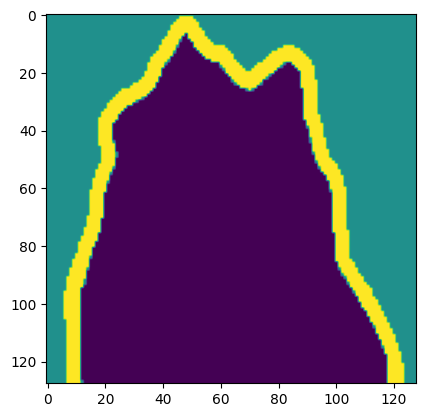

In [18]:
# 첫번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0], (128,128)))